<a href="https://colab.research.google.com/github/sefrancogo/Analitica-de-Datos/blob/master/Covid_Paises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediccion de Contagios por Covid-19



### Cargar Base de Datos


In [101]:
!pip install wget 
import pandas as pd
import numpy as np 
import wget 
import matplotlib.pyplot as plt
%matplotlib inline

url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
#path = 'data/Casos_positivos_de_COVID-19_en_Colombia04_15_2020.csv'

wget.download(url, 'datos_covid_paises.cvs')
data = pd.read_csv('datos_covid_paises.cvs')
data

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,8,8,14,16,16,16,23
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,6,7,10,10,12
264,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,3


### Dividir el conjunto de Datos


In [0]:
#funcion ventaneo
def covid_win(serie,w=5):
    pi = 0
    pf = w
    X = serie[pi:pf].reshape(1,-1)
    y = serie[pf+1].reshape(1,-1)
    #pi += 1
    #pf += 1
    #print(serie.shape[0])
    while pf+1 <   serie.shape[0]:        
        X = np.append(X,serie[pi:pf].reshape(1,-1),axis=0)
        y = np.append(y,serie[pf+1].reshape(1,-1),axis=0)
        pi += 1
        pf += 1
    return X, y # X \in Real^{N x P = w}, y \in Real^N

In [103]:
#Ubicar Posicion de pais
ii = data[data.columns[1]] == 'Colombia'

#contagios  acumulados
serie = np.array(data.iloc[np.where(ii)[0][0],4:])
#numero contagiados por dia
serie_d = np.append(0,np.diff(serie))
#serie_d = np.append(0,np.cumsum(np.diff(serie)))

X, y = covid_win(serie,w=5)
X_d, y_d = covid_win(serie_d,w=5)


prueba = serie[-5:-1]
prueba1 = np.append(prueba, serie[-1])
prueba1

array([6507, 7006, 7285, 7668, 7973], dtype=object)

In [104]:
data.iloc[82]

Province/State         NaN
Country/Region    Colombia
Lat                 4.5709
Long              -74.2973
1/22/20                  0
                    ...   
4/30/20               6507
5/1/20                7006
5/2/20                7285
5/3/20                7668
5/4/20                7973
Name: 82, Length: 108, dtype: object

In [105]:
X[-1]

array([5949, 6207, 6507, 7006, 7285], dtype=object)

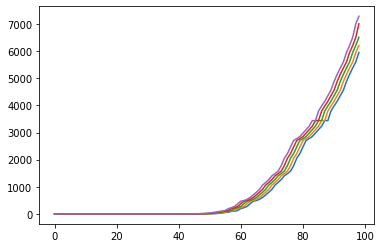

In [106]:
plt.plot(X)

### Análisis Exploratorio PCA

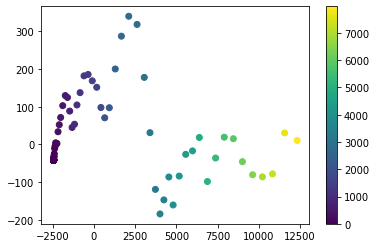

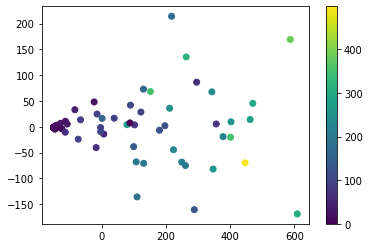

In [107]:
from sklearn.decomposition import PCA

red = PCA()
red_d = PCA()

z = red.fit_transform(X)
z_d = red_d.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()

plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()

### Análisis Exploratorio TSNE

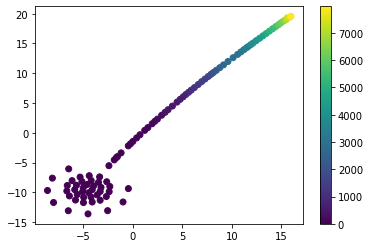

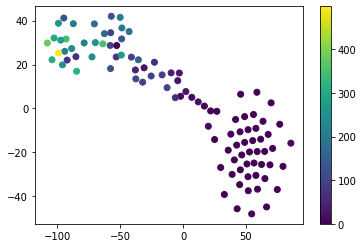

In [108]:
from sklearn.manifold import TSNE

red = TSNE(n_components = 2, perplexity=10)
red_d = TSNE(n_components = 2, perplexity=10)

z = red.fit_transform(X)
z_d = red.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()

plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()

### Extrer conjunto de Entrenamiento y Prueba
Cuando se tienen pocos datos es necesario realizar una validaación cruzada anidada.

### Función Validación Cruzada Anidada


In [0]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from joblib import dump, load

def V_Cruzada_Anidada(X_data,Y_data,steps,parameters):
  
  Niter = 10                           #numero particiones outter loop nested cross-validation
  msev = np.zeros((Niter,len(steps)))  #arreglo para guardar acierto
  best_estimators = []                 #mejor metodo por iteracion
  ###clave del funcionamiento
  best_hyperpar = []                   #mejor metodo por iteracion 
            

  for j in range(Niter): #outter loop
      print('it %d/%d'%(j+1,Niter))
      #particiono datos outter loop
      X_train, X_test, y_train, y_test = train_test_split(X_data,Y_data,test_size=0.3) # xtrain 60, xtest 26

      for r in range(len(steps)): #recorro todos los posibles modelos a probar en iteracion j del outter loop
          grid_search = GridSearchCV(Pipeline(steps[r]), parameters[r],cv=5,verbose=10,scoring='neg_mean_absolute_error',n_jobs=5) #cv inner loop
          #xtrain gridsearchcv xtrain split en 12 / cv, 60/5 = 12, xtrain 48 datos validar 12
          # cv = N -> leave one out N <30
          
          #generar mejor modelo
          grid_search.fit(X_train,y_train)
          
          #estimar salida conjunto de test
          y_pred = grid_search.best_estimator_.predict(X_test)
          
          #guardar mejor modelo
          best_estimators.append(grid_search.best_estimator_)
          best_hyperpar.append(grid_search.best_params_)

          #guardar acierto
          msev[j,r] = mse(y_test,y_pred)
          #print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r,len(steps)))
          #print(best_hyperpar)
          #print('mse:',msev[j,r])

          savedata = {
            'acc':msev,
            'best_models':best_estimators,
            'best_parameters':best_hyperpar,
              } 
          #dump(savedata,'covid19_1.joblib')

  return best_estimators,best_hyperpar,msev

#### Validación Cruzada Anidada LR:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearRegression



In [110]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  LinearRegression())],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  LinearRegression())]
          ]

parameters = [
                {
                 },
                {
                 'rep__n_components':[0.5,0.75,0.9]
                 }
               ]

label_model_LR = ['NorSC-LR','NorSC-PCA-LR']

B_Model_LR, B_Hiperpara_LR, MAE_LR = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    2.1s remaining:    1.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0242s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 2/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 3/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0047s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0104s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Para

Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 4/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 5/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0044s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Para

it 6/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 7/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 8/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0111s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0111s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   6 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0114s.) Settin

it 9/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 10/10
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0067s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0088s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Para

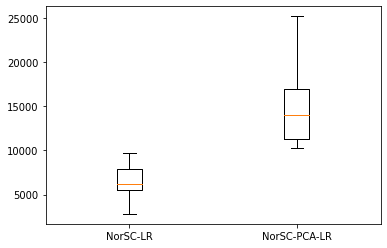

In [111]:
plt.boxplot(MAE_LR)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_LR)
plt.show()

In [112]:
MAE_LR

array([[ 5665.67113381, 10298.2578331 ],
       [ 4463.48117847, 13431.15975475],
       [ 9686.7915859 , 14710.90126796],
       [ 8373.99825747, 11358.69139829],
       [ 2796.752872  , 16445.65030235],
       [ 5998.55754514, 25239.13456156],
       [ 8234.31375184, 10355.13805102],
       [ 7092.66144303, 11222.85642202],
       [ 6308.27639261, 17553.64806838],
       [ 5463.39137728, 17125.7724376 ]])

In [113]:
B_Hiperpara_LR

[{},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5},
 {},
 {'rep__n_components': 0.5}]

In [114]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', LinearRegression())]

Mod_SC_LR = Pipeline(steps = steps)
Mod_SC_LR.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [115]:
from datetime import date
Xn = prueba1
#Xn = [4881, 5142, 5379, 5948, 6207]
#Xn=np.matrix([Xn])

Xn = Xn.reshape(1,-1)
Pre_SC_LR = Mod_SC_LR.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearRegression:',Pre_SC_LR)

Número de contagiados en los últimos 5 días: [[6507 7006 7285 7668 7973]]
Predicción contagios para 2020-05-06 usando un modelo LinearRegression: [[8813.88228121]]


#### Validación Cruzada Anidada Ridge:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearRidge


In [116]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  Ridge( ))],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  Ridge())]
          ]

parameters = [
                {'reg__alpha':[1e-3,1e-2,1e-1,1],
                 'reg__solver':['svd', 'cholesky', 'lsqr', 'sag', 'saga']
                 },
                {'rep__n_components':[0.5,0.9],
                 'reg__alpha':[1e-3,1e-2,1e-1,1],
                 'reg__solver':['svd', 'cholesky', 'lsqr', 'sag', 'saga']
                 }
               ]

label_model_R = ['NorSC-R','NorSC-PCA-R']

B_Model_R, B_Hiperpara_R, MAE_R = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0075s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0315s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0445s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  66 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  81 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  92 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fa

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0901s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0727s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 125 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 141 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 163 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 176 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 189 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0060s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0

it 2/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0800s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0105s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0489s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0561s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1380s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0073s.) Setting batch_size=2.


it 3/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0342s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0711s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0063s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0063s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks   

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1246s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 125 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 141 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 163 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 176 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 189 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0093s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0368s.) Setting batch_size=4

it 4/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0694s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0095s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0482s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0654s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0971s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 147 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with

it 5/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0082s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0400s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0720s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0108s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks   

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0976s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1990s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0073s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0387s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks  

it 6/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0087s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0400s.) Setting batch_size=4.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0604s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1019s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0070s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0344s.)

it 7/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0969s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0074s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0535s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0711s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1182s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0075s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

it 8/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0378s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0721s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0091s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0600s.) Setting batch_size=4.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0745s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1053s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0074s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 9/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0455s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0747s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0161s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0323s.) Setting batch_size=4.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0564s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0986s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0072s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0484s.)

it 10/10
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0721s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0084s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0416s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0853s.) Setting batch_size=8.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1054s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 172 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 185 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    0.7s finished


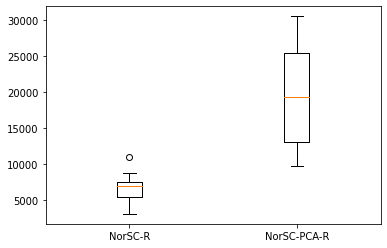

In [117]:
plt.boxplot(MAE_R)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_R)
plt.show()

In [118]:
MAE_R

array([[ 3068.99431097,  9683.11000041],
       [ 8773.64693181, 26852.90087912],
       [ 7207.13813071, 17514.47942525],
       [ 4417.37408741, 16158.1328043 ],
       [ 5355.74454071, 11984.51147826],
       [ 7657.30721779, 21143.69716112],
       [10915.5260528 , 30538.44429656],
       [ 7286.72260105, 26516.05508199],
       [ 5746.19200127, 11840.89409807],
       [ 6550.93198137, 22206.75643193]])

In [119]:
B_Hiperpara_R

[{'reg__alpha': 0.01, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.1, 'reg__solver': 'saga', 'rep__n_components': 0.9},
 {'reg__alpha': 0.001, 'reg__solver': 'cholesky'},
 {'reg__alpha': 0.01, 'reg__solver': 'sag', 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.1, 'reg__solver': 'saga', 'rep__n_components': 0.9},
 {'reg__alpha': 0.001, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.001, 'reg__solver': 'sag', 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__solver': 'lsqr'},
 {'reg__alpha': 1, 'reg__solver': 'sag', 'rep__n_components': 0.9},
 {'reg__alpha': 0.001, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.1, 'reg__solver': 'sag', 'rep__n_components': 0.9},
 {'reg__alpha': 0.01, 'reg__solver': 'cholesky'},
 {'reg__alpha': 0.01, 'reg__solver': 'saga', 'rep__n_components': 0.9},
 {'reg__alpha': 0.01, 'reg__solver': 'lsqr'},
 {'reg__alpha': 0.001, 'reg__solver': 'sag', 'rep__n_components': 0.9},
 {'reg__alpha': 0.01, 'reg__solver': 'lsqr'},
 {'reg

In [120]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', Ridge(alpha=0.001, solver='lsqr'))]

Mod_SC_R = Pipeline(steps = steps)
Mod_SC_R.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='lsqr', tol=0.001))],
         verbose=False)

In [121]:
Xn = prueba1
#Xn = [4881, 5142, 5379, 5948, 6207]
#Xn=np.matrix([Xn])

Xn = Xn.reshape(1,-1)
Pre_SC_R = Mod_SC_R.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearRidge:',Pre_SC_R)

Número de contagiados en los últimos 5 días: [[6507 7006 7285 7668 7973]]
Predicción contagios para 2020-05-06 usando un modelo LinearRidge: [[8830.72242783]]


#### Validación Cruzada Anidada Lasso:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearLasso

In [122]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  Lasso())],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  Lasso())]
          ]

parameters = [
                {'reg__alpha':[1e-3,1e-2,1e-1,1],
                 },
                {'rep__n_components':[0.5,0.75,0.9],
                 'reg__alpha':[1e-3,1e-2,1e-1,1],
                 }
               ]

label_model_L = ['NorSC-L','NorSC-PCA-L']

B_Model_L, B_Hiperpara_L, MAE_L = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0180s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204041.7896648115, tolerance: 26914.08091594203
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0104s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed: 

it 2/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0489s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0708s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  35 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0080s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0080s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s


it 3/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  17 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160676.73595821933, tolerance: 32455.62829855072
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0092s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0408s.) Setting batch_size=4.
[Para

it 4/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0552s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  51 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s


it 5/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done  11 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  17 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 251474.46773391473, tolerance: 31588.334147826085
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0075s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0662s.) Setting

it 6/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done  44 out of  60 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  51 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0177s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase

it 7/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0405s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0087s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 8/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137958.38059021265, tolerance: 30685.969481159427
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0052s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Bat

it 9/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0566s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0370s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  58 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    0.2s finished


it 10/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0084s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64669.06857549405, tolerance: 29526.1997768116
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0123s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.01

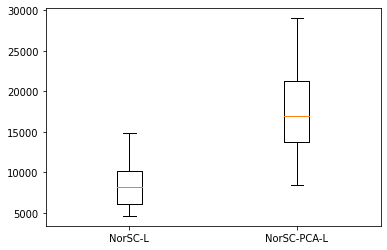

In [123]:
plt.boxplot(MAE_L)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_L)
plt.show()

In [124]:
MAE_L

array([[ 5958.8700814 ,  8454.34553671],
       [ 5204.20221125, 14293.70105375],
       [14869.09502552, 29041.6377097 ],
       [ 8876.04467353, 13307.67441773],
       [ 4614.20884031, 13640.72709237],
       [10347.87508793, 22739.45443058],
       [ 9663.88988692, 16802.77185117],
       [12407.64570157, 22198.94041093],
       [ 7406.73598023, 18381.72423562],
       [ 6288.53100164, 17187.98391381]])

In [125]:
B_Hiperpara_L

[{'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1},
 {'reg__alpha': 0.001, 'rep__n_components': 0.5},
 {'reg__alpha': 1},
 {'reg__alpha': 1, 'rep__n_components': 0.5}]

In [126]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', Ridge(alpha=0.1))]

Mod_SC_L = Pipeline(steps = steps)
Mod_SC_L.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 Ridge(alpha=0.1, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [127]:
Xn = prueba1
#Xn = [4881, 5142, 5379, 5948, 6207]
#Xn=np.matrix([Xn])

Xn = Xn.reshape(1,-1)
Pre_SC_L = Mod_SC_L.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearLasso:',Pre_SC_L)

Número de contagiados en los últimos 5 días: [[6507 7006 7285 7668 7973]]
Predicción contagios para 2020-05-06 usando un modelo LinearLasso: [[8901.58203771]]


#### Validación Cruzada Anidada EN:

- Normalización StandadScalar
- Representación PCA
- Regresor LinearElasticNet

In [128]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  ElasticNet())],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  ElasticNet( ))]
          ]

parameters = [
                {'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__l1_ratio':[1e-3,1e-2,5e-1,75e-1,1e-1,1,10,100]
                 },
                {'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__l1_ratio':[1e-3,1e-2,5e-1,75e-1,1e-1,1,10,100],
                  'rep__n_components':[0.5,0.75,0.9]
                 }
               ]

label_model_EN = ['NorSC-EN','NorSC-PCA-EN']

B_Model_EN, B_Hiperpara_EN, MAE_EN = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0070s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0475s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0636s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1064s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 166 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1330s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_desce

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0646s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1246s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 643 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 656 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0072s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0072s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks  

it 2/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0787s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1102s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 147 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 186 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 212 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172759.23184517075, tolerance: 34696.26069855073
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0092s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks   

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1114s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 665 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0091s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0422s.) Setting batch_size=4.


it 3/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1144s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1804s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 206 out of 240 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209658.33170869717, tolerance: 36126.81617391305
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0129s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0631s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1204s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1051s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1840s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 539 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 583 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 658 tasks   

it 4/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0465s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1066s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0749s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1800s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204019.4430773657, tolerance: 31928.575747826082
  positive)
[Parallel(n_jobs=5)]: Using back

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0498s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0992s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 628 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 671 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0079s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

it 5/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0535s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0854s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1590s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0900s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204733.10860290544, tolerance: 28817.486507246376
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1055s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 628 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 671 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0131s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0131s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0695s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.1s


it 6/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1820s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  94 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 166 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 191 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 209 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 222 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 231 out of 240 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 245196.75060472827, tolerance: 32722.684576811596
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0173s.) Se

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0614s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1069s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1308s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 539 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 583 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 596 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 673 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 705 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent worker

it 7/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1939s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1216s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 296158.6056855131, tolerance: 33170.26633333333
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0120s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0369s.) Setting batch_size=4.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0778s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1111s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1981s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 539 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 583 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 627 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 642 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 705 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.3s finished
[Parallel(n

it 8/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0526s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0611s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1250s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1945s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235833.9885742008, tolerance: 29

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0132s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0422s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0645s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1868s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  94 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1143s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 182 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 406 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 541 tasks   

it 9/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0212s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0379s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1078s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1030s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1878s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 206 out of 240 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0142s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0401s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1041s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1065s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 665 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with

it 10/10
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0744s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1075s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1526s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 206 out of 240 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177407.528473076, tolerance: 30444.6987768116
  positive)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: B

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=5)]: Done  54 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1788s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 110 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 182 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 350 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 526 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 659 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 672 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 702 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 711 out of 720 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 720 out of 720 | elapsed:    2.3s finished


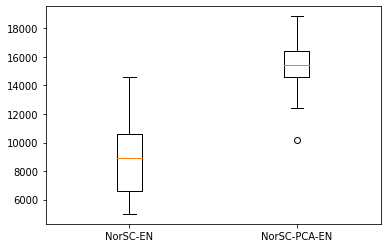

In [129]:
plt.boxplot(MAE_EN)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_EN)
plt.show()

In [130]:
MAE_EN

array([[ 9230.50207252, 15248.74741583],
       [14580.88167713, 15437.8026129 ],
       [ 6201.55247433, 17076.80149901],
       [ 9134.38549157, 16507.49569937],
       [ 8762.17681077, 15382.14448247],
       [12808.60624102, 12430.3614513 ],
       [ 5770.71485696, 10162.52376085],
       [11064.87457657, 16165.7035438 ],
       [ 4997.04413235, 18847.105992  ],
       [ 7671.19481735, 14342.02498467]])

In [131]:
B_Hiperpara_EN

[{'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.01, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.01, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 0.5},
 {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'rep__n_components': 0.5},
 {'reg__alpha': 0.1, 'reg__l1_ratio': 1},
 {'reg__alpha': 0.01, 'reg__l1_ratio': 7.5

In [132]:
steps =  [('scaler', StandardScaler()),
          #('rep', PCA(n_components=0.5)),                         
          ('reg', ElasticNet(alpha=0.001, l1_ratio=1))]

Mod_SC_EN = Pipeline(steps = steps)
Mod_SC_EN.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215681.14552552009, tolerance: 33623.87946086956
  positive)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=1, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [133]:
Xn = prueba1
#Xn = [4881, 5142, 5379, 5948, 6207]
#Xn=np.matrix([Xn])

Xn = Xn.reshape(1,-1)
Pre_SC_EN = Mod_SC_EN.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearElasticNet:',Pre_SC_EN)

Número de contagiados en los últimos 5 días: [[6507 7006 7285 7668 7973]]
Predicción contagios para 2020-05-06 usando un modelo LinearElasticNet: [8965.88934796]


#### Validación Cruzada Anidada KR:

- Normalización StandadScalar
- Representación PCA
- Regresor KernelRidge

In [134]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atributo columna de xtrain centrada en 0 y var = 1
          ('reg',  KernelRidge(kernel = 'rbf'))],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  KernelRidge(kernel = 'rbf'))]
          ]

parameters = [
                {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__alpha':[1e-3,1e-2,1e-1,1,10,100]
                 },
                {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
                 'rep__n_components':[0.5,0.75,0.9]
                 }
               ]

label_model_KR = ['NorSC-KRRBF','NorSC-PCA-KRRBF']

B_Model_KR, B_Hiperpara_KR, MAE_KR = V_Cruzada_Anidada(X,y,steps,parameters)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0135s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0529s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0768s.) Setting batch_size=8.


it 1/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1659s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0169s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0733s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1083s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1291s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0076s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0076s.)

it 2/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1047s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 119 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 142 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 153 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 164 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0165s.) Setting batch_size=2.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0524s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1013s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1427s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]:

it 3/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0927s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1599s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0173s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0613s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0858s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1304s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0081s.) Setting batch_size=2

it 4/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1270s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1445s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 122 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0113s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0113s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0868s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1276s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1678s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 194 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 366 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 408 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 452 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 496 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 511 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 526 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n

it 5/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0737s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1414s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0623s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0809s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1357s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers

it 6/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0790s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1123s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0105s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0105s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0939s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1299s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 178 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 468 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0081s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0081s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0545s.) Setting batch_size=8.


it 7/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0744s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 133 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 142 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 153 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 164 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0096s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0096s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0798s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0956s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1756s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 210 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 325 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 367 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 409 tasks   

it 8/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0778s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1041s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0537s.) Setting batch_size=8.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1658s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 194 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 338 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 469 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0111s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0111s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s


it 9/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0984s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1646s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 102 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 146 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 157 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 171 out of 180 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0076s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0076s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0719s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1271s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 178 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0152s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0424s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


it 10/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0630s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0828s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0162s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0162s.) Setting batch_size=4.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1042s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 158 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 246 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 334 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 438 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 500 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 531 out of 540 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.9s finished


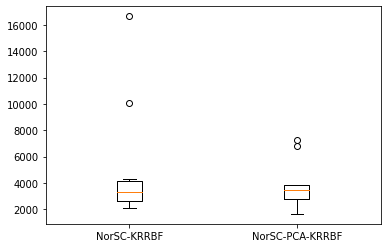

In [135]:
plt.boxplot(MAE_KR)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model_KR)
plt.show()

In [136]:
val = 100*100
cont = -1
for i in range(MAE_KR.shape[0]):
  for j in range(MAE_KR.shape[1]):
    cont +=1    
    if (val > MAE_KR[i,j]):
      val = MAE_KR[i,j]
      pos = cont

print(pos)
print(val)

3
1657.4753053626166


In [137]:
MAE_KR

array([[ 3255.03455896,  3605.96926727],
       [ 4268.02814869,  1657.47530536],
       [ 2447.52129551,  3849.56041811],
       [ 3069.77233266,  2114.41299292],
       [16644.31746675,  7249.00293148],
       [ 3677.10524897,  3108.67521264],
       [ 2476.35328324,  2698.55513747],
       [ 2106.0257449 ,  3403.36822709],
       [10094.47492946,  6807.93504411],
       [ 3438.15088628,  3741.98445545]])

In [138]:
B_Model_KR[pos]

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)

In [139]:
print(B_Hiperpara_KR[pos])
B_Hiperpara_KR

{'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}


[{'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5},
 {'reg__alpha': 0.001, 'reg__gamma': 0.01},
 {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_compone

In [140]:
steps =  [('scaler', StandardScaler()),
          ('rep', PCA(n_components=0.5)),                         
          ('reg', KernelRidge(alpha=0.001, kernel='rbf', gamma=0.01))]

Mod_SC_PCA_KRrbf = Pipeline(steps = steps)
Mod_SC_PCA_KRrbf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.01,
                             kernel='rbf', kernel_params=None))],
         verbose=False)

In [141]:
Xn = prueba1
#Xn = [4881, 5142, 5379, 5948, 6207]
#Xn=np.matrix([Xn])

Xn = Xn.reshape(1,-1)
Pre_SC_PCA_KRrbf = Mod_SC_PCA_KRrbf.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo KernelRidge_rbf:',Pre_SC_PCA_KRrbf)

Número de contagiados en los últimos 5 días: [[6507 7006 7285 7668 7973]]
Predicción contagios para 2020-05-06 usando un modelo KernelRidge_rbf: [[9073.84781399]]


In [142]:
print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción contagios para',date.today(),'usando un modelo LinearRegression:',Pre_SC_LR)
print('Predicción contagios para',date.today(),'usando un modelo LinearRidge:',Pre_SC_R)
print('Predicción contagios para',date.today(),'usando un modelo LinearLasso:',Pre_SC_L)
print('Predicción contagios para',date.today(),'usando un modelo LinearElasticNet:',Pre_SC_EN)
print('Predicción contagios para',date.today(),'usando un modelo KernelRidge_rbf:',Pre_SC_PCA_KRrbf)

Número de contagiados en los últimos 5 días: [[6507 7006 7285 7668 7973]]
Predicción contagios para 2020-05-06 usando un modelo LinearRegression: [[8813.88228121]]
Predicción contagios para 2020-05-06 usando un modelo LinearRidge: [[8830.72242783]]
Predicción contagios para 2020-05-06 usando un modelo LinearLasso: [[8901.58203771]]
Predicción contagios para 2020-05-06 usando un modelo LinearElasticNet: [8965.88934796]
Predicción contagios para 2020-05-06 usando un modelo KernelRidge_rbf: [[9073.84781399]]
